# Applying Rocket to Raw Audio

Note: this notebook is extremely messy as a result of me trying to rapidly prototype rocket for raw audio and not following best practices. It also uses the beta version of fastai v2 for removing silence and preprocessing. If you are interested in experimenting yourself and can't make sense of something here, please reach out to [me](https://forums.fast.ai/u/madeupmasters/summary) by PM, or in the [Deep Learning with Audio](https://forums.fast.ai/t/deep-learning-with-audio-thread) or [Time Series](https://forums.fast.ai/t/time-series-sequential-data-study-group) threads

This notebook will apply the findings of the recent [Rocket Paper](https://arxiv.org/abs/1910.13051) by Angus Dempster, François Petitjean, Geoffrey I. Webb to 1D raw audio signals for the task of voice recognition. Some of this code is also adapted from [Ignacio Oguiza](https://forums.fast.ai/u/oguiza) and his [Time Series Module for FastAI v1](https://github.com/timeseriesAI/timeseriesAI)

Initially the signals were too long and slow to train at a sample rate of 16000 (was going to take ~30-40 minutes for 1s clips). Training a 3800 audio 10 class dataset (small problem, trains to 99%+ accuracy in 2 minutes using typical audio pipeline of spectrogram + CNN), . To speed things up I added a stride which sped up results without a drop in accuracy, but still only led to 85% accuracy after 4 minutes of training. Removing silence and doubling the amount of time to 2s allowed us to get great results (95% accuracy in 6s, 98.6% in 20 seconds, 99.2% in 1 min 20 sec).

Unfortunately so far, I have not been able to scale the results to harder problems, such as a 250 speaker dataset. 

## Summary of Findings

In order to spare you having to go through this network, here's a summary of the interesting results

 - 95% accuracy in 6s, 98.6% in 20 seconds, 99.2% in 1 min 20 sec on a 10 class problem using raw audio and no augmentation
 - Having a stride of 5-7 seems to be an optimal balance between computational cost and accuracy
 - Bigger filter sizes are better only up to 7x7 or 9x9 and then they actually decrease accuracy with increased cost
 - A variety of filter sizes (7,9,11) doesnt seem to beat out just individual filter sizes 7,9,11 but more testing is needed with a harder dataset
 - Testing tons of individual kernels on random subsets of the data and then selecting the best ones actually results in less accuracy vs the same number of random kernels (this is likely due to increased correlation between the good random kernels, making them worse in an ensemble)

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from local.torch_basics import *
from local.test import *
from local.basics import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.audio.augment import *
from local.vision.learner import *
from local.vision.models.xresnet import *
from local.metrics import *
from local.callback.schedule import *
import torchaudio
from fastprogress import progress_bar as pb
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV
from rocket import generate_kernels, apply_kernel, apply_kernels

In [ ]:
p10speakers = Config()['data_path'] / 'ST-AEDS-20180100_1-OS'
untar_data(URLs.SPEAKERS10, fname=str(p10speakers)+'.tar', dest=p10speakers)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [ ]:
get_audio = AudioGetter("", recurse=True, folders=None)
files_10 = get_audio(p10speakers)

In [ ]:
files_10

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
audio_opener = OpenAudio(files_10)
p10_labeler = lambda x: str(x).split('/')[-1][:5] #grab the label from each file

In [ ]:
CLIP_LENGTH = 2000

In [ ]:
sigs, labels = [],[]
cropper = CropSignal(CLIP_LENGTH, pad_mode='repeat')
remove_silence = RemoveSilence()
for i in pb(range(len(files_10))):
    sigs.append(cropper(remove_silence(audio_opener(i))).sig)
    labels.append(p10_labeler(files_10[i]))

In [ ]:
len(sigs), len(labels)

(3842, 3842)

In [ ]:
total_size = len(sigs)
train_size = int(total_size*.8)
train_idxs = torch.randperm(total_size)[:train_size]
valid_idxs = [i for i in range(total_size) if i not in train_idxs]

In [ ]:
assert len(train_idxs) + len(valid_idxs) == len(sigs)

In [ ]:
x_train = [sigs[idx].squeeze(0).numpy() for idx in train_idxs]
y_train = [labels[idx] for idx in train_idxs]
x_valid = [sigs[idx].squeeze(0).numpy() for idx in valid_idxs]
y_valid = [labels[idx] for idx in valid_idxs]

In [ ]:
list(map(len, (x_train, y_train, x_valid, y_valid)))

[3073, 3073, 769, 769]

In [ ]:
np_x_train = np.stack(x_train).astype(np.float64)
np_x_valid = np.stack(x_valid).astype(np.float64)
np_x_train.shape, np_x_valid.shape

((3073, 32000), (769, 32000))

In [ ]:
o2i_f = lambda x: 5*(x[0]=='m') + int(x[-1]) - 1

In [ ]:
np_y_train = np.array(list(map(o2i_f, y_train)))
np_y_valid = np.array(list(map(o2i_f, y_valid)))

In [ ]:
np_y_train

array([0, 7, 2, ..., 0, 7, 1])

In [ ]:
np_x_train.shape, np_y_train.shape, np_x_valid.shape, np_y_valid.shape

((3073, 32000), (3073,), (769, 32000), (769,))

In [ ]:
np_x_train.mean()

-4.49039649777175e-05

### Normalize the training data

In [ ]:
np_x_train = (np_x_train - np_x_train.mean(axis = 1, keepdims = True)) / (np_x_train.std(axis = 1, keepdims = True) + 1e-8)
np_x_valid = (np_x_valid - np_x_valid.mean(axis = 1, keepdims = True)) / (np_x_valid.std(axis = 1, keepdims = True) + 1e-8)

In [ ]:
np_x_train.mean(), np_x_train.std()

(-8.10809639770585e-20, 0.9999995545301024)

In [ ]:
np_x_train.dtype

dtype('float64')

# Start Here

In [ ]:
def timing_test(runs, candidate_lengths, stride, num_kernels, seq_length, show_progress=True):
    times, scores = [],[]
    for i in range(runs):
        kernels = generate_kernels(seq_length, num_kernels, candidate_lengths, stride)
        start = time.time()
        x_train_tfm = apply_kernels(np_x_train, kernels)
        x_valid_tfm = apply_kernels(np_x_valid, kernels)
        classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
        classifier.fit(x_train_tfm, np_y_train)
        score = classifier.score(x_valid_tfm, np_y_valid)
        t = time.time()-start
        scores.append(score)
        times.append(t)
        if(show_progress): print("Finished Run", i+1, "Score:", round(score, 3), "Time:", round(t,3))
    return times, scores

# Initial attempts

In [ ]:
timing_test(5, np.array((7,9,11)), stride=5, num_kernels=200, seq_length=16000)

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 7       | .85     |  4:02 |
| {7,9,11}         | 5       | .899    |  5:20  |
| {7,9,11}         | 3       | .903    |  8:15  |
|{800,1000,1200}   | 400     | .46     |  3:43  |


**Silence removed results 10000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .979     |  5:08 |
| {7,9,11}         | 5       | .976     |  5:10 |
| {7,9,11}         | 5       | .980     |  5:26 |


**Silence removed results 2000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}          | 5       | .972     |  1:10 |
| {7,9,11}         | 5       | .979     |  1:03 |
| {7,9,11}         | 5       | .976     |  1:01 |

**Silence removed results 1000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .974     |  0:31 |
| {7,9,11}         | 5       | .974     |  0:31 |
| {7,9,11}         | 5       | .966     |  0:31 |

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .949     |  0:06 |
| {7,9,11}         | 5       | .950     |  0:06 |
| {7,9,11}         | 5       | .934     |  0:06|

## 1s Audio, silence removed, testing strides

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 1       | .942     |  0:30 |
| {7,9,11}         | 1       | .954     |  0:28 |
| {7,9,11}         | 1       | .950     |  0:28|

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 3       | .960     |  0:10 |
| {7,9,11}         | 3       | .948     |  0:10 |
| {7,9,11}         | 3       | .954     |  0:10 |

## Up clip length to 2 seconds

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 5       | .987     |  0:15 |
| {7,9,11}         | 5       | .980     |  0:13 |
| {7,9,11}         | 5       | .986     |  0:13 |

**Silence removed results 200 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 3       | .986     |  0:20 |
| {7,9,11}         | 3       | .986     |  0:20 |
| {7,9,11}         | 3       | .990     |  0:20 |

**Silence removed results 1000 kernels**

| Kernel Sizes     | Strides | Results |  Time  |
| :--------------: | :-----: | :-----: | :-----:|      
| {7,9,11}         | 3       | .992     |  1:40 |
| {7,9,11}         | 3       | .992     |  1:40 |
| {7,9,11}         | 3       | .992     |  1:40 |

## Check impact of the kernel size options, do we really need to choose from 3?

In [ ]:
times_ks2, scores_ks2 = timing_test(10, np.array((2,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks3, scores_ks3 = timing_test(10, np.array((3,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks5, scores_ks5 = timing_test(10, np.array((5,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)


In [ ]:
times_ks7, scores_ks7 = timing_test(10, np.array((7,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks9, scores_ks9 = timing_test(10, np.array((9,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks11, scores_ks11 = timing_test(10, np.array((11,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ksorig, scores_ksorig = timing_test(10, np.array((7,9,11,)), stride=1, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
def mn(x): return round(sum(x)/len(x), 3)

In [ ]:
all_scores = [scores_ks2, scores_ks3, scores_ks5, scores_ks7, scores_ks9, scores_ks11, scores_ksorig,]
all_times = [times_ks2, times_ks3, times_ks5, times_ks7, times_ks9, times_ks11, times_ksorig,]

In [ ]:
mean_times = list(map(mn, all_times))
mean_scores = list(map(mn, all_scores))

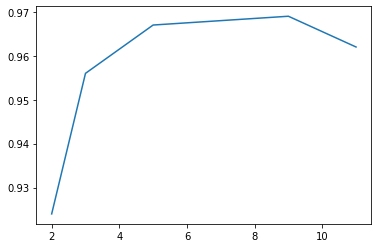

In [ ]:
plt.plot([2,3,5,7,9,11], mean_scores[:6])


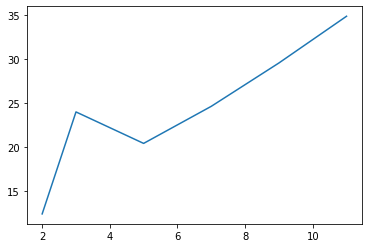

In [ ]:
plt.plot([2,3,5,7,9,11], mean_times[:6])

In [ ]:
mean_scores

[0.924, 0.956, 0.967, 0.968, 0.969, 0.962, 0.967]

### Conclusion: It appears 7,9,11 do well, it's hard to tell if the variety helps without testing a higher number of kernels

Let's rerun the last experiment, this time with longer strides

In [ ]:
times_ks2, scores_ks2 = timing_test(10, np.array((2,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks3, scores_ks3 = timing_test(10, np.array((3,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks5, scores_ks5 = timing_test(10, np.array((5,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)


In [ ]:
times_ks7, scores_ks7 = timing_test(10, np.array((7,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks9, scores_ks9 = timing_test(10, np.array((9,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ks11, scores_ks11 = timing_test(10, np.array((11,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
times_ksorig, scores_ksorig = timing_test(10, np.array((7,9,11,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)

In [ ]:
all_scores_s7 = [scores_ks2, scores_ks3, scores_ks5, scores_ks7, scores_ks9, scores_ks11, scores_ksorig,]
all_times_s7 = [times_ks2, times_ks3, times_ks5, times_ks7, times_ks9, times_ks11, times_ksorig,]

In [ ]:
mean_times_s7 = list(map(mn, all_times_s7))
mean_scores_s7 = list(map(mn, all_scores_s7))

In [ ]:
mean_scores_s7

[0.905, 0.937, 0.949, 0.95, 0.958, 0.951, 0.957]

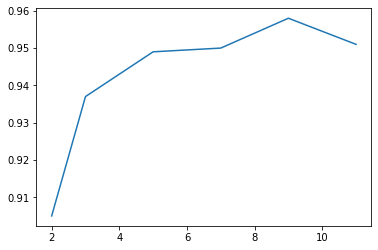

In [ ]:
plt.plot([2,3,5,7,9,11], mean_scores_s7[:6])

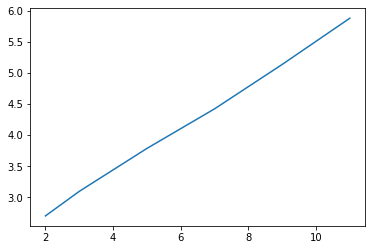

In [ ]:
plt.plot([2,3,5,7,9,11], mean_times_s7[:6])

In [ ]:
def mn(x): return round(sum(x)/len(x),3)

## Test 100 kernels each of larger kernels

In [ ]:
scores_ks, times_ks = [],[]
for kernel_size in range(7,100,4):
    times, scores = timing_test(1, np.array((kernel_size,)), stride=7, num_kernels=100, seq_length=32000, show_progress=False)
    print(f"Kernel Size {kernel_size}: Score: {mn(scores)} Time: {mn(times)}s")
    scores_ks.append(mn(scores))
    times_ks.append(mn(times))

Kernel Size 7: Score: 0.952 Time: 5.322s
Kernel Size 11: Score: 0.962 Time: 6.52s
Kernel Size 15: Score: 0.956 Time: 7.862s
Kernel Size 19: Score: 0.965 Time: 8.23s
Kernel Size 23: Score: 0.943 Time: 9.699s
Kernel Size 27: Score: 0.953 Time: 11.522s
Kernel Size 31: Score: 0.941 Time: 12.626s
Kernel Size 35: Score: 0.948 Time: 12.208s
Kernel Size 39: Score: 0.947 Time: 11.937s
Kernel Size 43: Score: 0.931 Time: 12.709s
Kernel Size 47: Score: 0.936 Time: 14.581s
Kernel Size 51: Score: 0.926 Time: 15.842s
Kernel Size 55: Score: 0.932 Time: 17.233s
Kernel Size 59: Score: 0.926 Time: 18.059s
Kernel Size 63: Score: 0.932 Time: 20.527s
Kernel Size 67: Score: 0.925 Time: 20.773s
Kernel Size 71: Score: 0.935 Time: 18.156s
Kernel Size 75: Score: 0.915 Time: 19.595s
Kernel Size 79: Score: 0.912 Time: 21.77s
Kernel Size 83: Score: 0.926 Time: 23.429s
Kernel Size 87: Score: 0.923 Time: 25.025s
Kernel Size 91: Score: 0.923 Time: 26.44s
Kernel Size 95: Score: 0.902 Time: 26.552s
Kernel Size 99: Score

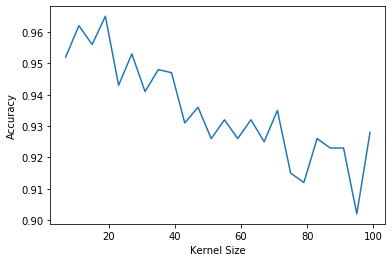

In [ ]:
plt.xlabel("Kernel Size")
plt.ylabel("Accuracy")
plt.plot(np.arange(7,100,4), scores_ks);

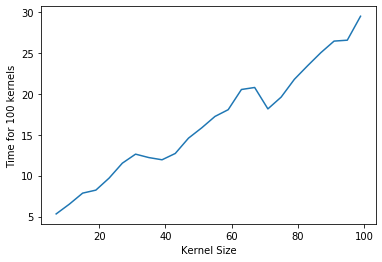

In [ ]:
plt.xlabel("Kernel Size")
plt.ylabel("Time for 100 kernels")
plt.plot(np.arange(7,100,4), times_ks);

### 3x3 kernel is twice as fast as 9x9, that means we can double the kernels and run in same time, but it still has worse results

In [ ]:
times_ks3, scores_ks3 = timing_test(10, np.array((2,)), stride=7, num_kernels=200, seq_length=32000, show_progress=False)

In [ ]:
mn(scores_ks3)

0.935

## Drop down to stride 1 conv, run 2500 kernels for filter size 7,9,11 and {7,9,11} to see if variety helps

In [ ]:
times_7, scores_7 = timing_test(1, np.array((7,)), stride=1, num_kernels=2500, seq_length=32000, show_progress=False)

In [ ]:
times_9, scores_9 = timing_test(1, np.array((9,)), stride=1, num_kernels=2500, seq_length=32000, show_progress=False)

In [ ]:
times_11, scores_11 = timing_test(1, np.array((11,)), stride=1, num_kernels=2500, seq_length=32000, show_progress=False)

In [ ]:
times_orig, scores_orig = timing_test(1, np.array((7,9,11,)), stride=1, num_kernels=2500, seq_length=32000, show_progress=False)

In [ ]:
mn(scores_7), mn(scores_9), mn(scores_11), mn(scores_orig)

(0.996, 0.996, 1.0, 0.995)

### Conclusion: Doesnt appear to help but needs to be retested on a tougher dataset

In [ ]:
times_7, times_9, times_11, times_orig

([600.959691286087],
 [723.5468919277191],
 [877.7471699714661],
 [831.6202943325043])

## What is the predictive power of a single kernel?

In [ ]:
times, scores = timing_test(20, np.array((7,9,11)), stride=5, num_kernels=1, seq_length=32000)

Finished Run 1 Score: 0.243 Time: 0.101
Finished Run 2 Score: 0.212 Time: 0.141
Finished Run 3 Score: 0.226 Time: 0.161
Finished Run 4 Score: 0.224 Time: 0.194
Finished Run 5 Score: 0.211 Time: 0.107
Finished Run 6 Score: 0.182 Time: 0.122
Finished Run 7 Score: 0.257 Time: 0.189
Finished Run 8 Score: 0.28 Time: 0.167
Finished Run 9 Score: 0.19 Time: 0.146
Finished Run 10 Score: 0.164 Time: 0.122
Finished Run 11 Score: 0.186 Time: 0.172
Finished Run 12 Score: 0.289 Time: 0.225
Finished Run 13 Score: 0.251 Time: 0.226
Finished Run 14 Score: 0.139 Time: 0.057
Finished Run 15 Score: 0.274 Time: 0.157
Finished Run 16 Score: 0.211 Time: 0.157
Finished Run 17 Score: 0.213 Time: 0.21
Finished Run 18 Score: 0.231 Time: 0.197
Finished Run 19 Score: 0.226 Time: 0.108
Finished Run 20 Score: 0.226 Time: 0.233


In [ ]:
sum(scores)/len(scores)

0.22178153446033813

### Answer: about 22% on a 10-class probelm

# Can we apply kernels to a small subset of our data and get enough data to see which ones will be predictive? if so we could generate 100x as many random kernels for a large dataset, select the best 1% and use those on full data

In [ ]:
def get_good_kernels(runs, candidate_lengths, stride, num_kernels, seq_length, thresh, subset_size=300, show_progress=True):
    good_kernels, scores = [], []
    for i in range(runs):
        candidate_lengths = np.array((7,))
        kernels = generate_kernels(seq_length, num_kernels, candidate_lengths, stride)
        idxs = torch.randperm(len(np_x_train))[:subset_size]
        #print(idxs)
        np_x_train_subset = np_x_train[idxs]
        np_y_train_subset = np_y_train[idxs]
        x_train_tfm = apply_kernels(np_x_train_subset, kernels)
        x_valid_tfm = apply_kernels(np_x_valid, kernels)
        classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
        classifier.fit(x_train_tfm, np_y_train_subset)
        score = classifier.score(x_valid_tfm, np_y_valid)
        if score > thresh:
            good_kernels.append(kernels)
        scores.append(score)
        if(show_progress): print("Finished Run", i+1, "Score:", round(score, 3))
    return good_kernels, scores

In [ ]:
k, s = get_good_kernels(2000, np.array((7,)), stride=5, num_kernels=1,seq_length=32000, thresh=0.275, show_progress=False)

In [ ]:
def merge_kernels(k):
    num_kernels = len(k)
    strides = np.zeros(num_kernels, dtype = np.int32)
    weights = np.zeros((num_kernels, 7)) # see note
    lengths = np.zeros(num_kernels, dtype = np.int32) # see note
    biases = np.zeros(num_kernels)
    dilations = np.zeros(num_kernels, dtype = np.int32)
    paddings = np.zeros(num_kernels, dtype = np.int32)
    for i in range(num_kernels):
        #weights, lengths, biases, dilations, paddings, strides
        weights[i], lengths[i], biases[i], dilations[i], paddings[i], strides[i] = k[i]
    return weights, lengths, biases, dilations, paddings, strides

In [ ]:
len(k)

165

In [ ]:
kernels = merge_kernels(k)

In [ ]:
times, scores = timing_test(10, np.array((7,)), stride=5, num_kernels=168, seq_length=32000, show_progress=True)

Finished Run 1 Score: 0.974 Time: 9.498
Finished Run 2 Score: 0.978 Time: 9.682
Finished Run 3 Score: 0.974 Time: 10.002
Finished Run 4 Score: 0.979 Time: 9.684
Finished Run 5 Score: 0.98 Time: 9.885
Finished Run 6 Score: 0.979 Time: 9.818
Finished Run 7 Score: 0.979 Time: 9.717
Finished Run 8 Score: 0.978 Time: 9.658
Finished Run 9 Score: 0.977 Time: 9.609
Finished Run 10 Score: 0.978 Time: 9.866


In [ ]:
def score_kernels(k):
    x_train_tfm = apply_kernels(np_x_train, k)
    x_valid_tfm = apply_kernels(np_x_valid, k)
    classifier = RidgeClassifierCV(alphas=np.logspace(-3, 3, 7), normalize=True)
    classifier.fit(x_train_tfm, np_y_train)
    score = classifier.score(x_valid_tfm, np_y_valid)
    return(score)

In [ ]:
score_kernels(kernels)

0.9687906371911573

## Result is that 168 "high accuracy" kernels drawn from 2000 random kernels actually performs worse than just 168 random kernels! The correlation between the high accuracy kernels must be higher than among the random ones, so they are picking out the same features more frequently

In [ ]:
min(s), max(s), mn(s)

(0.4967490247074122, 0.5357607282184655, 0.52)